In [190]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.utils.data
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from deap import algorithms, base, creator, tools
import copy
import operator

In [2]:
# load all data
data = pd.read_csv('SFEW.csv',  header=None, skiprows=1)

# drop first column
data.drop(data.columns[0], axis=1, inplace=True)

#remove Nan PHOG descriptor pattern
data.drop([205], axis=0, inplace=True)

# try shuffle data
data = data.sample(frac=1).reset_index(drop=True)

#normalisation of features
for column in data:
    if column == 1:
        pass
    else:
        data[column] = data.loc[:, [column]].apply(lambda x: (x - x.mean()) / x.std())
        
# stratified split into training set (50%) and testing set (50%)
X = data.iloc[:,1:11].values
Y = data.iloc[:,0].values-1
x1, x2, y1, y2 = train_test_split(X, Y, train_size=0.5, random_state=42, stratify=Y)

In [3]:
def data_prep(x1,x2,y1,y2):
    train_x, train_y = torch.Tensor(x1), torch.Tensor(y1).long()
    test_x, test_y = torch.Tensor(x2), torch.Tensor(y2).long()
    train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    return list([train_x, train_y, test_x, test_y, train_loader])

# prepare the 2-fold cross-validation datasets as lists of tensors and a training loader
data1 = data_prep(x1,x2,y1,y2)
data2 = data_prep(x2,x1,y2,y1)

In [4]:
# define the three-layer neural network
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        first = self.fc1(x)
        act = self.sigmoid(first)
        out = self.fc2(act)
        return act, out  #outputs both the hidden layer activation matrix and the output classification
    
# define the loss function
criterion = nn.CrossEntropyLoss()

In [5]:
# training step for batch training
def train_step(model, optimizer, loader):
    for step, (batch_x, batch_y) in enumerate(loader):
        X = batch_x
        Y = batch_y.long()
        _, outputs = model(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        return loss.item()

# distinctiveness pruning step
def prune(model, x, theta):
    n_neu = model.fc1.weight.data.size(0) #initial number of neurons
    activation, _ = model(x)
    cos = nn.CosineSimilarity(dim=0, eps=1e-6) # calculates cosine similarity between column vectors
    activation += torch.full(activation.size(), -0.5) #normalise activation vectors
    keep = list(range(n_neu)) #generate list of column indices to keep track of neurons
    for j in range(n_neu):
        for k in range(j+1,n_neu):
            angle = cos(activation[:,j],activation[:,k])
            n_neu = model.fc1.weight.data.size(0)
            if angle.item() >= math.cos(math.radians(theta)) and k in keep:  # similar neurons
                model.fc1.weight.data[j] += model.fc1.weight.data[k]
                model.fc1.bias.data[j] += model.fc1.bias.data[k]
                model.fc2.weight.data[:,j] += model.fc2.weight.data[:,k] # adds together all weights and biases from k to j
                keep.remove(k) #removes neuron k from list
            if angle.item() <= math.cos(math.radians(180-theta)) and k in keep and j in keep: # complementary neurons
                keep.remove(k) #removes neuron k and j from list
                keep.remove(j)
    model.fc1.weight.data = model.fc1.weight.data[keep]
    model.fc2.weight.data = model.fc2.weight.data[:,keep] # removes all relevant weights and biases from the model
    model.fc1.bias.data = model.fc1.bias.data[keep]
    return model

In [15]:
#classification accuracy
def accuracy(model, X, Y):
    _, outputs = model(X)
    _, predicted = torch.max(outputs, 1)
    total = predicted.size(0)
    correct = sum(predicted.data.numpy() == Y.data.numpy())
    return 100*correct/total

In [132]:
num_hidden = 100
lr = 0.01
net = Net(10, num_hidden, 7)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
for epoch in range(300):
    train_step(net, optimizer, data1[4])
    
print('neurons:', num_hidden,', lr: ', lr)
print('Training Accuracy: %.2f %%' % accuracy(net, data1[0], data1[1]))
print('Testing Accuracy: %.2f %%' % accuracy(net, data1[2], data1[3]))

neurons: 100 , lr:  0.01
Training Accuracy: 33.83 %
Testing Accuracy: 18.69 %


In [135]:
N = num_hidden

#genetic algorithm
toolbox = base.Toolbox()
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

#create chromosomes with N bits corresponding to on or off hidden units
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, N)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

#crossover
toolbox.register("mate", tools.cxOnePoint)

#mutation
toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)

def evaluation(individual,net,data,N,lam):
    model = copy.deepcopy(net)
    #turn chromosome into keep list
    keep = [i for i, x in enumerate(individual) if x == 1]
    #keep hidden neurons in model, remove all others
    model.fc1.weight.data = model.fc1.weight.data[keep]
    model.fc2.weight.data = model.fc2.weight.data[:,keep] # removes all relevant weights and biases from the model
    model.fc1.bias.data = model.fc1.bias.data[keep]
    #check fitness
    fitness = accuracy(model, data[2], data[3]) - lam*len(keep)/N
    return [fitness]
toolbox.register("evaluate", lambda x: evaluation(x, net, data1, N, 20))

toolbox.register("select", tools.selTournament, tournsize=3)
hof = tools.HallOfFame(5)

pop = toolbox.population(n=100)

Training accuracy of the best individual:  32.93768545994065
Testing accuracy of the best individual:  24.62908011869436
Number of hidden neurons: 26
Network reduction proportion: 26.0 %


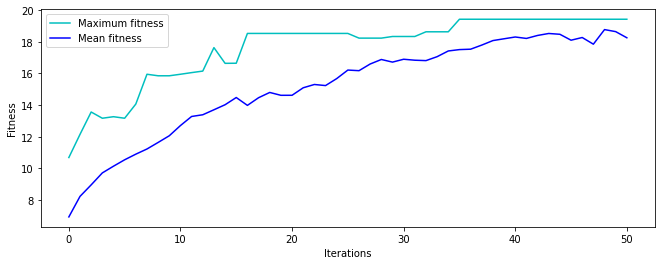

In [136]:
fit_stats = tools.Statistics(key=operator.attrgetter("fitness.values"))
fit_stats.register('mean', np.mean)
fit_stats.register('max', np.max)
result, log = algorithms.eaSimple(toolbox.population(n=100), toolbox,
                                  cxpb=0.8, mutpb=0.2,
                                  ngen=50, halloffame=hof, verbose=False,
                                  stats=fit_stats)
plt.figure(figsize=(11, 4))
plots = plt.plot(log.select('max'),'c-', log.select('mean'), 'b-')
plt.legend(plots, ('Maximum fitness', 'Mean fitness'), frameon=True)
plt.ylabel('Fitness'); plt.xlabel('Iterations');

best_individual = tools.selBest(result, k=1)[0]
best_keep = [i for i, x in enumerate(best_individual) if x == 1]
print('Training accuracy of the best individual: ', evaluation2(best_individual, net, data1[0],data1[1], N)[0])
print('Testing accuracy of the best individual: ', evaluation2(best_individual, net, data1[2],data1[3], N)[0])
print('Number of hidden neurons:', len(best_keep))
print('Network reduction proportion:', len(best_keep)/N*100, '%')

Fitness of the best individual:  27.002967359050444
[2, 3, 12, 31, 33, 39, 40, 41, 42, 46]
Fitness of the best individual:  24.92581602373887


In [105]:
def evaluation2(individual,net,X,Y,N):
    model = copy.deepcopy(net)
    #turn chromosome into keep list
    keep = [i for i, x in enumerate(individual) if x == 1]
    #keep hidden neurons in model, remove all others
    model.fc1.weight.data = model.fc1.weight.data[keep]
    model.fc2.weight.data = model.fc2.weight.data[:,keep] # removes all relevant weights and biases from the model
    model.fc1.bias.data = model.fc1.bias.data[keep]
    #check fitness
    fitness = accuracy(model, X, Y)
    return [fitness]

In [195]:
#genetic algorithm hyperparameter testing

def evaluation(individual,net,data,N,lam):
    model = copy.deepcopy(net)
    #turn chromosome into keep list
    keep = [i for i, x in enumerate(individual) if x == 1]
    #keep hidden neurons in model, remove all others
    model.fc1.weight.data = model.fc1.weight.data[keep]
    model.fc2.weight.data = model.fc2.weight.data[:,keep] # removes all relevant weights and biases from the model
    model.fc1.bias.data = model.fc1.bias.data[keep]
    #check fitness
    fitness = accuracy(model, data[2], data[3]) - lam*len(keep)/N
    return [fitness]

def GA(net, N, lam, data):
    toolbox = base.Toolbox()
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)
    toolbox.register("attr_bool", random.randint, 0, 1)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, N)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", tools.cxOnePoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
    toolbox.register("evaluate", lambda x: evaluation(x, net, data, N, lam))
    toolbox.register("select", tools.selTournament, tournsize=3)
    hof = tools.HallOfFame(5)
    pop = toolbox.population(n=100)
    
    fit_stats = tools.Statistics(key=operator.attrgetter("fitness.values"))
    fit_stats.register('mean', np.mean)
    fit_stats.register('max', np.max)
    result, log = algorithms.eaSimple(toolbox.population(n=100), toolbox, cxpb=0.8, mutpb=0.2, ngen=50, halloffame=hof, verbose=False,
                                      stats=fit_stats)
    
    best_individual = tools.selBest(result, k=1)[0]
    best_keep = [i for i, x in enumerate(best_individual) if x == 1]
    f_train = evaluation2(best_individual, net, data1[0],data1[1], N)[0]
    f_test = evaluation2(best_individual, net, data1[2],data1[3], N)[0]
    f_N = len(best_keep)
    f_N_perc = len(best_keep)/N*100
    return f_train, f_test, f_N, f_N_perc

def GA_func(N_list, lam_list, data):
    N_data = []
    for N in N_list:
        net = Net(10, N, 7)
        optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
        for epoch in range(300):
            train_step(net, optimizer, data[4])
        i_train = accuracy(net, data[0], data[1])
        i_test = accuracy(net, data[2], data[3])
        
        lam_data = []
        for lam in lam_list:
            f_train, f_test, f_N, f_N_perc = GA(net, N, lam, data)
            lam_data.append([N, lam, i_train, i_test, f_train, f_test, f_N, f_N_perc])
        N_data.append(np.array(lam_data))
    
    return np.stack(N_data)

In [188]:
N_list = [20,50,100,200,500]
lam_list = [0,1,2,3,4,5,10,20,50]

hyp_data = np.mean(np.array([GA_func(N_list, lam_list, data) for data in folded_data]), axis=0)

/Users/u6676643/opt/anaconda3/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/u6676643/opt/anaconda3/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


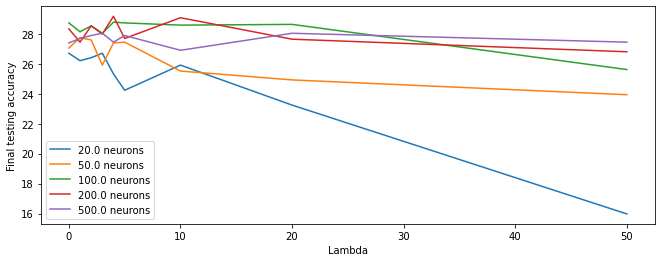

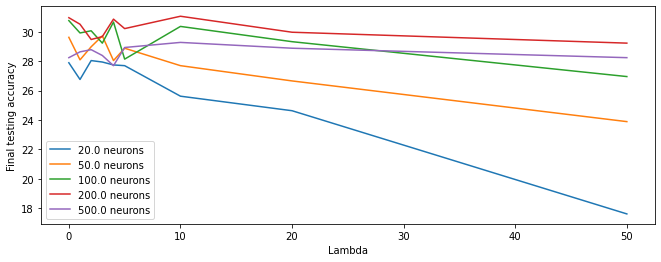

In [198]:
plt.figure(figsize=(11, 4))
for i in range(len(N_list)):
    plt.plot(lam_list, hyp_data[i,:,5], label=str(hyp_data[i,0,0])+' neurons')
plt.legend()
plt.ylabel('Final testing accuracy'); plt.xlabel('Lambda');

plt.figure(figsize=(11, 4))
for i in range(len(N_list)):
    plt.plot(lam_list, hyp_data[i,:,4], label=str(hyp_data[i,0,0])+' neurons')
plt.legend()
plt.ylabel('Final testing accuracy'); plt.xlabel('Lambda');

In [196]:
N_list = [20,50,100,200,500]
lam1_list = [0,0.1,0.25,0.5,0.75,1,2]

def evaluation(individual,net,data,N,lam):
    model = copy.deepcopy(net)
    #turn chromosome into keep list
    keep = [i for i, x in enumerate(individual) if x == 1]
    #keep hidden neurons in model, remove all others
    model.fc1.weight.data = model.fc1.weight.data[keep]
    model.fc2.weight.data = model.fc2.weight.data[:,keep] # removes all relevant weights and biases from the model
    model.fc1.bias.data = model.fc1.bias.data[keep]
    #check fitness
    fitness = accuracy(model, data[2], data[3]) - lam*len(keep)
    return [fitness]

hyp_data1 = np.mean(np.array([GA_func(N_list, lam1_list, data) for data in [data1,data2] for x in range(3)]), axis=0)

/Users/u6676643/opt/anaconda3/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/u6676643/opt/anaconda3/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


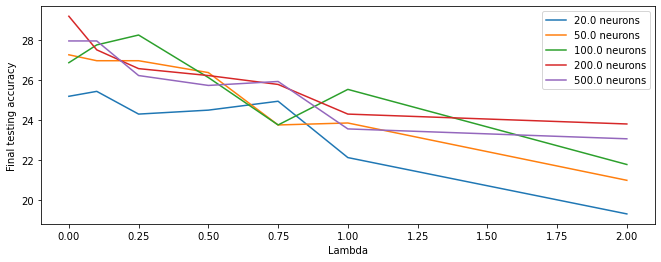

In [197]:
plt.figure(figsize=(11, 4))
for i in range(len(N_list)):
    plt.plot(lam1_list, hyp_data1[i,:,5], label=str(hyp_data1[i,0,0])+' neurons')
plt.legend()
plt.ylabel('Final testing accuracy'); plt.xlabel('Lambda');